In [100]:
import pandas as pd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Dataset containing links to the reports
Downloaded file from the Sustainability Reporting Navigator

https://docs.google.com/spreadsheets/d/1Nlyf8Yz_9Fst8rEmQc2IMc-DWLF1fpmBTB7n4FlZwxs/edit?gid=0#gid=0 
date: 14.08.2025

In [101]:
# read in csv
srn_reports_raw = pd.read_csv("SRN-CSRD_report_archive - csrd.csv", header=2)
print(srn_reports_raw.head())

  verified      srn_id        company          isin  country publication date  \
0      yes  tVkXa1OoYn     Netcompany  DK0060952919  Denmark       2025-01-29   
1      yes  4P9CZx30gn           Tryg  DK0060636678  Denmark       2025-01-23   
2      yes  u63Ki9uBLF  DSV Panalpina  DK0060079531  Denmark       2025-02-04   
3      yes  PtoavXijSQ       Lundbeck  DK0061804697  Denmark       2025-02-04   
4      yes  g5GXXjndDy         Vestas  DK0061539921  Denmark       2025-02-05   

  claim full CSRD compliance   auditor  start PDF  end PDF  pages PDF  \
0                       True        EY       62.0    154.0       93.0   
1                       True       PwC       53.0    131.0       79.0   
2                       True       PwC       42.0     84.0       43.0   
3                       True       PwC       59.0    144.0       86.0   
4                       True  Deloitte       51.0    132.0       82.0   

                                                link ESEF-\ntagged  \
0   

In [102]:
# drop all rows where 'verified' is not yes
esrs_reports = srn_reports_raw[srn_reports_raw['verified'] == 'yes']
print(len(esrs_reports))

# keep only relevant columns
esrs_reports = esrs_reports[['company', 'isin', 'country', 'publication date', 'auditor', 'link', 'SASB industry \n(SICS® Industries)']]
# rename columns
esrs_reports = esrs_reports.rename(columns={
    'publication date': 'publication_date',
    'SASB industry \n(SICS® Industries)': 'SASB_industry'
})

627


In [103]:
# save as excel
esrs_reports.to_excel("esrs_reports.xlsx", index=False)

# Dataset with company info

retrieved all company data with the help of ISIN code from LSEG (where isin was available)

In [104]:
company_data = pd.read_excel("lseg_data.xlsx", header=2)
print(company_data.head())
print(len(company_data))

     srn_company      srn_isin srn_country    Unnamed: 3  \
0     Netcompany  DK0060952919     Denmark  DK0060952919   
1           Tryg  DK0060636678     Denmark  DK0060636678   
2  DSV Panalpina  DK0060079531     Denmark  DK0060079531   
3       Lundbeck  DK0061804697     Denmark  DK0061804697   
4         Vestas  DK0061539921     Denmark  DK0061539921   

       Company Common Name          ISIN       RIC Country of Headquarters  \
0     Netcompany Group A/S  DK0060952919  NETCG.CO                 Denmark   
1                 Tryg A/S  DK0060636678   TRYG.CO                 Denmark   
2                  DSV A/S  DK0060079531    DSV.CO                 Denmark   
3           H Lundbeck A/S  DK0061804697  HLUNa.CO                 Denmark   
4  Vestas Wind Systems A/S  DK0061539921    VWS.CO                 Denmark   

         GICS Sector Name  Number of Employees Social Pillar Score  \
0  Information Technology               7927.0           57.975414   
1              Financials     

In [105]:
# drop unnecessary columns
company_data = company_data.drop(columns=['Unnamed: 3'])

In [106]:
# drop NAs
company_data = company_data.dropna()
print(len(company_data))


500


In [107]:
# drop all companys with above 750 employees
company_data = company_data[company_data['Number of Employees'] >= 750]
print(len(company_data))

479


### Control for mismatches between srn and lseg info

In [108]:
# print all rows where srn_isin and ISIN are not the same
mismatched_isin = company_data[company_data['srn_isin'] != company_data['ISIN']]
print(mismatched_isin)

         srn_company      srn_isin  srn_country         Company Common Name  \
12     GN Store Nord  DK0010272632      Denmark                   TomTom NV   
13            Ørsted  DK0060094928      Denmark           GN Store Nord A/S   
14             Mærsk  DK0010244425      Denmark                 Oersted A/S   
15             Solar  DK0010274844      Denmark     AP Moeller - Maersk A/S   
16         Carlsberg  DK0010181759      Denmark                   Solar A/S   
..               ...           ...          ...                         ...   
570  Astarta Holding  NL0000686509  Netherlands                   Qiagen NV   
571          Ubisoft  FR0000054470       France  Assicurazioni Generali SpA   
572              CCC  PLCCC0000016       Poland               Frequentis AG   
573             Aker  NO0010234552       Norway                  Fluidra SA   
574    Aker Horizons  NO0010921232       Norway                    Snam SpA   

             ISIN               RIC Country of Head

In [109]:
# print all rows where srn_country and Country of Headquarters are not the same
mismatched_country = company_data[company_data['srn_country'] != company_data['Country of Headquarters']]
print(mismatched_country)

              srn_company      srn_isin  srn_country  \
12          GN Store Nord  DK0010272632      Denmark   
19                  Barco  BE0974362940      Belgium   
20               Randstad  NL0000379121  Netherlands   
21                 Genmab  DK0010272202      Denmark   
22             Stora Enso  FI0009005961      Finland   
..                    ...           ...          ...   
569  Naturgy Energy Group  ES0116870314        Spain   
571               Ubisoft  FR0000054470       France   
572                   CCC  PLCCC0000016       Poland   
573                  Aker  NO0010234552       Norway   
574         Aker Horizons  NO0010921232       Norway   

            Company Common Name          ISIN        RIC  \
12                    TomTom NV  NL0013332471    TOM2.AS   
19              Danske Bank A/S  DK0010274414  DANSKE.CO   
20                     Barco NV  BE0974362940     BAR.BR   
21                  Randstad NV  NL0000379121    RAND.AS   
22                   Genmab

In [110]:
# look at all mismatches in the names
    # 1. prepare standardizes names (remove sa, se, nv, ag, a/s)

def standardize_name(name):
    name = name.lower()
    name = name.replace(" sa", "").replace(" se", "").replace(" nv", "").replace(" ag", "").replace(" a/s", "").replace(" oyj", "").replace(" ab", "").replace(" abp", "").replace(" plc", "").replace(" spa", "").replace(" asa", "").replace(" nyrt", "")
    name = name.strip()
    return name

# compare standardized "srn_company" and "Company Common Name"
company_data['srn_company_std'] = company_data['srn_company'].apply(standardize_name)
company_data['Company Common Name_std'] = company_data['Company Common Name'].apply(standardize_name)
mismatched_names = company_data[company_data['srn_company_std'] != company_data['Company Common Name_std']]
print(mismatched_names)

         srn_company      srn_isin  srn_country         Company Common Name  \
0         Netcompany  DK0060952919      Denmark        Netcompany Group A/S   
2      DSV Panalpina  DK0060079531      Denmark                     DSV A/S   
3           Lundbeck  DK0061804697      Denmark              H Lundbeck A/S   
4             Vestas  DK0061539921      Denmark     Vestas Wind Systems A/S   
12     GN Store Nord  DK0010272632      Denmark                   TomTom NV   
..               ...           ...          ...                         ...   
570  Astarta Holding  NL0000686509  Netherlands                   Qiagen NV   
571          Ubisoft  FR0000054470       France  Assicurazioni Generali SpA   
572              CCC  PLCCC0000016       Poland               Frequentis AG   
573             Aker  NO0010234552       Norway                  Fluidra SA   
574    Aker Horizons  NO0010921232       Norway                    Snam SpA   

             ISIN               RIC Country of Head

## Descriptives

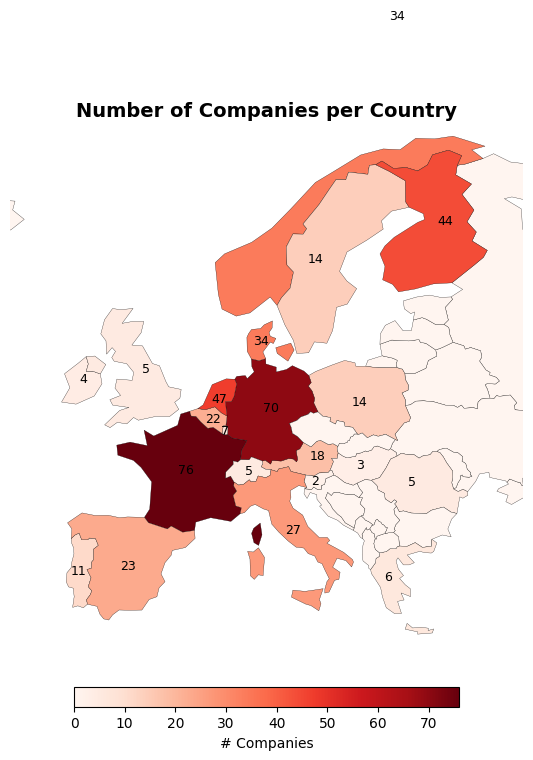

In [111]:
# Load shapefile
world = gpd.read_file("earth/ne_110m_admin_0_countries.shp")

# Filter on Europe only
europe = world[world['CONTINENT'] == 'Europe']

# Count companies per country
country_counts = company_data["Country of Headquarters"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

# Merge counts with Europe geometry
europe_counts = europe.merge(country_counts, left_on="NAME", right_on="country", how="left")
europe_counts["count"] = europe_counts["count"].fillna(0)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Define colors
cmap = cm.Reds
min_rate, max_rate = europe_counts["count"].min(), europe_counts["count"].max()
norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

# Plot map with white for missing values (0 count)
europe_counts.plot(
    column='count',
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.2,
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "# Companies",
        "orientation": "horizontal",
        "shrink": 0.5,   # smaller legend
        "pad": 0.02      # closer to map
    },
    missing_kwds={
        "color": "white",     # countries with 0 count are white
        "edgecolor": "black",
        "hatch": None
    }
)

# Add country labels using representative points
for idx, row in europe_counts.iterrows():
    if row["count"] > 0:  # only label if > 0
        x, y = row.geometry.representative_point().coords[0]
        ax.text(x, y, int(row["count"]), ha="center", va="center", fontsize=9, color="black")

# Custom axis
ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)
ax.axis('off')

plt.title("Number of Companies per Country", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


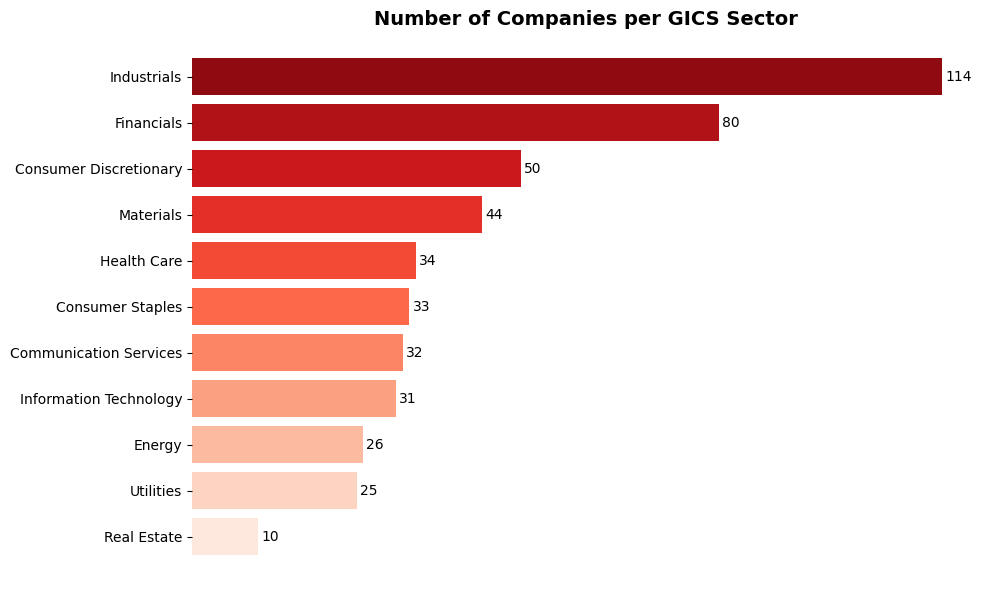

In [112]:
# Count companies per sector
sector_counts = (
    company_data["GICS Sector Name"]
    .value_counts()
    .reset_index()
)
sector_counts.columns = ["Sector", "Count"]

# Sort sectors so highest count is first
sector_counts = sector_counts.sort_values("Count", ascending=True).reset_index(drop=True)

# Create color palette from light to dark red (highest count = darkest red)
colors = sns.color_palette("Reds", n_colors=len(sector_counts))

# Assign colors based on sorted order
color_map = dict(zip(sector_counts["Sector"], colors))
bar_colors = sector_counts["Sector"].map(color_map)

# Plot (horizontal bar chart)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    y=sector_counts["Sector"],
    width=sector_counts["Count"],
    color=bar_colors
)

# Add counts at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{int(width)}",
            va="center", ha="left", fontsize=10)

# Style
ax.set_title("Number of Companies per GICS Sector", fontsize=14, weight="bold")
ax.set_xlabel("")  # remove x-axis label
ax.xaxis.set_visible(False)  # hide x-axis ticks and labels
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(False)  # remove grid lines

plt.tight_layout()
plt.show()

In [113]:
# descriptive table with min, max, mean, median, std about: Company Market Capitalization, Number of Employees, social pillar score, workforce score
desc_table = company_data[['Company Market Capitalization', 'Number of Employees', 'Social Pillar Score', 'Workforce Score']].describe()

In [114]:
company_data['Company Market Capitalization'].describe()

count      479.000000
unique     478.000000
top       5305.884086
freq         2.000000
Name: Company Market Capitalization, dtype: float64

In [121]:

# Select the columns you want
cols = [
    "Company Market Capitalization",
    "Number of Employees",
    "Workforce Score"
]

# Calculate descriptive statistics
desc_table = pd.DataFrame({
    "Min": company_data[cols].min(),
    "Max": company_data[cols].max(),
    "Mean": company_data[cols].mean(),
    "Median": company_data[cols].median(),
    "Std Dev": company_data[cols].std(),
    "Total Observations": len(company_data[cols]),
})


# Optional: Rename index to nice format
desc_table.index.name = "Variable"

# Display table
desc_table


,Min,Max,Mean,Median,Std Dev,Total Observations
Variable,,,,,,
Company Market Capitalization,46.073889,317967.15035,17009.59028,4671.118481,37298.261096,479
Number of Employees,751.0,651917.0,33798.317328,11000.0,64623.661049,479
Workforce Score,9.22528,99.828179,76.003854,80.662021,19.784173,479


In [116]:
print(desc_table)

                                     Min           Max          Mean  \
Variable                                                               
Company Market Capitalization  46.073889  317967.15035   17009.59028   
Number of Employees                751.0      651917.0  33798.317328   
Workforce Score                  9.22528     99.828179     76.003854   

                                    Median       Std Dev  Total Observations  
Variable                                                                      
Company Market Capitalization  4671.118481  37298.261096                 479  
Number of Employees                11000.0  64623.661049                 479  
Workforce Score                  80.662021     19.784173                 479  


Company Market Capitalization in Million Euros